In [ ]:
# To predict the 2-days net change in stock prices using Lasso Regression with K-fold cross-validation


In [241]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import SelectFromModel, f_regression
from sklearn.linear_model import LinearRegression, Lasso 
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from scipy.stats import f
import researchpy as rp 
from scipy import stats
from sklearn.impute import SimpleImputer
import statsmodels.api as sm

np.random.seed(1234)
import warnings

from sklearn import set_config
set_config(display="diagram") #setting this will display your pipelines as seen above

warnings.filterwarnings("ignore")


In [215]:
# Loading data 
data = pd.read_csv("C:/Users/Luswata/Dropbox/ML_AI_UCBerkeley/Data/semis_futures.csv")
data.shape

(44610, 59)

In [216]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44610 entries, 0 to 44609
Data columns (total 59 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   y_netdiff2                 44610 non-null  float64
 1   net_diff1                  44610 non-null  float64
 2   symbol                     44610 non-null  object 
 3   extractdte                 44610 non-null  object 
 4   yyyymm                     44610 non-null  object 
 5   mth                        44610 non-null  int64  
 6   wk                         44610 non-null  int64  
 7   dowk                       44610 non-null  int64  
 8   domth                      44610 non-null  int64  
 9   last                       44610 non-null  float64
 10  key_chartp                 44610 non-null  int64  
 11  rsi_3d_n                   40793 non-null  float64
 12  rsi_3d_pchg1               36779 non-null  float64
 13  rsi_9d_n                   44610 non-null  flo

In [217]:
data.columns

Index(['y_netdiff2', 'net_diff1', 'symbol', 'extractdte', 'yyyymm', 'mth',
       'wk', 'dowk', 'domth', 'last', 'key_chartp', 'rsi_3d_n', 'rsi_3d_pchg1',
       'rsi_9d_n', 'rsi_9d_pchg1', 'rsi_9d_pchg2', 'rsi_9d_pchg5', 'rsi_20d_n',
       'Pcnt_stoch3', 'Pcnt_k_stoch_d', 'Pcnt_di14d_up_above_dn',
       'Pcnt_5d_mvavg_50d', 'Pcnt_Above_mvavg_5d', 'Pcnt_Above_mvavg_50d',
       'Pcnt_Above_mvavg_20d', 'Pcnt_Above_mvavg_200d', 'Pcnt_Above_bb20dl',
       'Pcnt_Above_AvgResist', 'Pcnt_Above_AvgPx_stock', 'crit9_52wk_ratio',
       'pt_below_52wk_high', 'pt_above_floor', 'pt_below_ceil',
       'pt_hammer_above_floor', 'pchg_floor_min1', 'pchg_floor_min0',
       'pchg_ceil_max0', 'macd_9d_n', 'macd_14d_pchg2', 'macd_14d_n',
       'hvol_cat', 'Fib_382pcnt_n', 'dcr', 'days_since_volspike',
       'days_since_target_raised', 'days_since_hvolb_1mth',
       'days_since_highprob_bull', 'days_since_drop_8',
       'days_since_bull_window', 'days_since_bull_strength',
       'days_since_bull

In [218]:
data.describe()

,y_netdiff2,net_diff1,mth,wk,dowk,domth,last,key_chartp,rsi_3d_n,rsi_3d_pchg1,...,days_since_bull_strength,days_since_bull_stoch,days_since_bull_rev,days_since_bull_hammer,days_since_bear_countered,days_since_bbl,bband_width,atr_3d_n,atr_9d_n,atr_14d_n
count,44610.000000,44610.000000,44610.000000,44610.000000,44610.000000,44610.000000,44610.000000,44610.000000,40793.000000,36779.000000,...,43843.000000,44046.000000,44413.000000,41361.000000,23706.000000,42448.000000,44132.000000,4.457800e+04,44101.000000,44101.000000
mean,-3.610022,1.035435,6.291728,25.633289,3.079175,15.736898,438.071309,0.897198,50.748147,39.735161,...,6.416463,2.473301,0.675253,29.995116,44.032734,24.385177,503.863048,5.647312e+04,10.327215,10.276852
std,22.592031,11.622286,3.333407,14.479259,1.403524,8.714342,423.903488,0.303704,28.283644,388.078601,...,10.528805,3.347665,1.952865,32.389136,46.502351,35.239832,1768.625365,6.882600e+06,20.528217,20.388602
min,-300.000000,-149.880000,1.000000,1.000000,1.000000,1.000000,7.480000,0.000000,0.000000,-100.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,1.399943e-01,-6.180000,-38.760000
25%,-8.160004,-2.090027,4.000000,15.000000,2.000000,8.000000,186.505000,1.000000,28.571430,-26.627290,...,0.000000,0.000000,0.000000,7.000000,10.000000,0.000000,56.470547,3.903336e+00,4.150000,4.180000
50%,-1.309998,0.270000,6.000000,23.000000,3.000000,15.000000,362.845000,1.000000,52.196380,-0.781879,...,1.000000,1.000000,0.000000,20.000000,28.000000,7.000000,135.403100,7.037013e+00,7.350000,7.380000
75%,3.098740,3.630005,9.000000,38.000000,4.000000,23.000000,501.905000,1.000000,74.146340,29.721240,...,8.000000,4.000000,0.000000,42.000000,63.000000,37.000000,351.226225,1.216001e+01,12.270000,12.230000
max,300.000000,150.000000,12.000000,52.000000,5.000000,31.000000,3239.320000,1.000000,99.997770,19628.260000,...,105.000000,40.000000,60.000000,259.000000,324.000000,204.000000,70082.560000,8.390000e+08,2810.710000,2801.470000


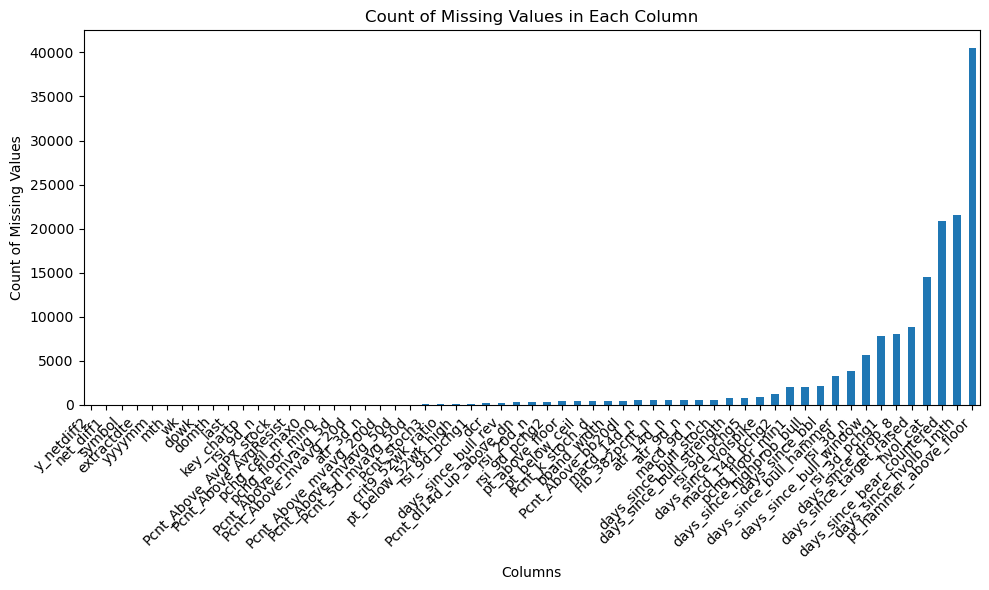

In [219]:
# Check misingness rates 
missing_values_count = data.isnull().sum().sort_values()

plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.title('Count of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot (optional)
plt.show()

In [220]:
# List of continuous variables to compute missing percentage for 
continuous_vars = ['key_chartp', 'rsi_3d_n', 'rsi_3d_pchg1','rsi_9d_n', 'rsi_9d_pchg1', 'rsi_9d_pchg2', 'rsi_9d_pchg5', 'rsi_20d_n','Pcnt_stoch3', 'Pcnt_k_stoch_d', 'Pcnt_di14d_up_above_dn','Pcnt_5d_mvavg_50d', 'Pcnt_Above_mvavg_5d', 'Pcnt_Above_mvavg_50d','Pcnt_Above_mvavg_20d', 'Pcnt_Above_mvavg_200d', 'Pcnt_Above_bb20dl','Pcnt_Above_AvgResist', 'Pcnt_Above_AvgPx_stock', 'crit9_52wk_ratio','pt_below_52wk_high', 'pt_above_floor', 'pt_below_ceil','pt_hammer_above_floor', 'pchg_floor_min1', 'pchg_floor_min0','pchg_ceil_max0', 'macd_9d_n', 'macd_14d_pchg2', 'macd_14d_n','hvol_cat', 'Fib_382pcnt_n', 'dcr', 'days_since_volspike','days_since_target_raised', 'days_since_hvolb_1mth','days_since_highprob_bull', 'days_since_drop_8','days_since_bull_window', 'days_since_bull_strength','days_since_bull_stoch', 'days_since_bull_rev','days_since_bull_hammer', 'days_since_bear_countered', 'days_since_bbl','bband_width', 'atr_3d_n', 'atr_9d_n', 'atr_14d_n']

# Loop over each variable to compute percent missingness and keep only those with > 5% missingness
selected_vars = []
for column_name in continuous_vars:
    missing_percentage = (data[column_name].isnull().sum() / len(data)) * 100
    if missing_percentage > 5:
        selected_vars.append(column_name)
        print(f"The percentage of missing values in column '{column_name}' is: {missing_percentage:.2f}%")

The percentage of missing values in column 'rsi_3d_n' is: 8.56%
The percentage of missing values in column 'rsi_3d_pchg1' is: 17.55%
The percentage of missing values in column 'pt_hammer_above_floor' is: 90.74%
The percentage of missing values in column 'hvol_cat' is: 32.47%
The percentage of missing values in column 'days_since_target_raised' is: 19.81%
The percentage of missing values in column 'days_since_hvolb_1mth' is: 48.24%
The percentage of missing values in column 'days_since_drop_8' is: 17.97%
The percentage of missing values in column 'days_since_bull_window' is: 12.73%
The percentage of missing values in column 'days_since_bull_hammer' is: 7.28%
The percentage of missing values in column 'days_since_bear_countered' is: 46.86%


In [221]:
# List of continuous variables to compute missing percentage for 
continuous_vars = ['key_chartp', 'rsi_3d_n', 'rsi_3d_pchg1','rsi_9d_n', 'rsi_9d_pchg1', 'rsi_9d_pchg2', 'rsi_9d_pchg5', 'rsi_20d_n','Pcnt_stoch3', 'Pcnt_k_stoch_d', 'Pcnt_di14d_up_above_dn','Pcnt_5d_mvavg_50d', 'Pcnt_Above_mvavg_5d', 'Pcnt_Above_mvavg_50d','Pcnt_Above_mvavg_20d', 'Pcnt_Above_mvavg_200d', 'Pcnt_Above_bb20dl','Pcnt_Above_AvgResist', 'Pcnt_Above_AvgPx_stock', 'crit9_52wk_ratio','pt_below_52wk_high', 'pt_above_floor', 'pt_below_ceil','pt_hammer_above_floor', 'pchg_floor_min1', 'pchg_floor_min0','pchg_ceil_max0', 'macd_9d_n', 'macd_14d_pchg2', 'macd_14d_n','hvol_cat', 'Fib_382pcnt_n', 'dcr', 'days_since_volspike','days_since_target_raised', 'days_since_hvolb_1mth','days_since_highprob_bull', 'days_since_drop_8','days_since_bull_window', 'days_since_bull_strength','days_since_bull_stoch', 'days_since_bull_rev','days_since_bull_hammer', 'days_since_bear_countered', 'days_since_bbl','bband_width', 'atr_3d_n', 'atr_9d_n', 'atr_14d_n']

# Loop over each variable to compute percent missingness and keep only those with <15% missingness
selected_vars = []
for column_name in continuous_vars:
    missing_percentage = (data[column_name].isnull().sum() / len(data)) * 100
    if missing_percentage >= 20:
        selected_vars.append(column_name)
        print(f"The percentage of missing values in column '{column_name}' is: {missing_percentage:.2f}%")

print("\nSelected variables with >= 20% missingness:")
print(selected_vars)

# Get the column names to keep from the main dataset
columns_to_drop = [col for col in data.columns if col not in selected_vars]
print("\nColumn names to retain:")
print(columns_to_drop)

The percentage of missing values in column 'pt_hammer_above_floor' is: 90.74%
The percentage of missing values in column 'hvol_cat' is: 32.47%
The percentage of missing values in column 'days_since_hvolb_1mth' is: 48.24%
The percentage of missing values in column 'days_since_bear_countered' is: 46.86%

Selected variables with >= 20% missingness:
['pt_hammer_above_floor', 'hvol_cat', 'days_since_hvolb_1mth', 'days_since_bear_countered']

Column names to retain:
['y_netdiff2', 'net_diff1', 'symbol', 'extractdte', 'yyyymm', 'mth', 'wk', 'dowk', 'domth', 'last', 'key_chartp', 'rsi_3d_n', 'rsi_3d_pchg1', 'rsi_9d_n', 'rsi_9d_pchg1', 'rsi_9d_pchg2', 'rsi_9d_pchg5', 'rsi_20d_n', 'Pcnt_stoch3', 'Pcnt_k_stoch_d', 'Pcnt_di14d_up_above_dn', 'Pcnt_5d_mvavg_50d', 'Pcnt_Above_mvavg_5d', 'Pcnt_Above_mvavg_50d', 'Pcnt_Above_mvavg_20d', 'Pcnt_Above_mvavg_200d', 'Pcnt_Above_bb20dl', 'Pcnt_Above_AvgResist', 'Pcnt_Above_AvgPx_stock', 'crit9_52wk_ratio', 'pt_below_52wk_high', 'pt_above_floor', 'pt_below_cei

In [222]:
# Drop columns missing >15% of the data
df = data.drop(columns=selected_vars)

In [223]:
# Impute missing values for remaining variables with median

# Identify numeric columns (int64 and float64)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate medians for each numeric column
medians = df[numeric_cols].median()

# Impute NaN values with respective column medians
df[numeric_cols] = df[numeric_cols].fillna(medians)



# print("Original DataFrame:")
# print(data.head(5))

# print("\nDataFrame after imputation with medians:")
# print(df.head(5))

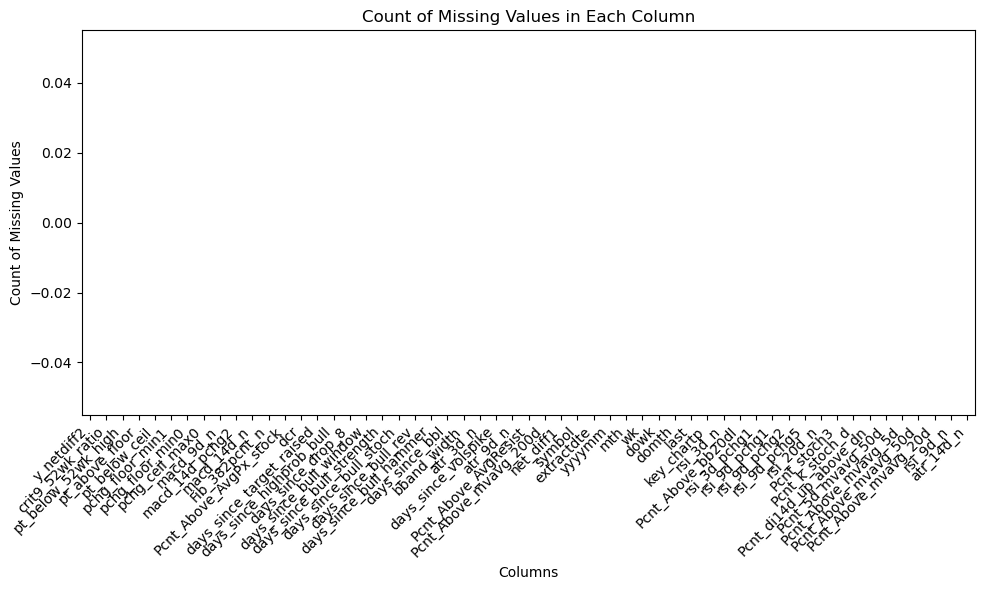

In [224]:
# Check misingness rates after imputation 
missing_values_count = df.isnull().sum().sort_values()

plt.figure(figsize=(10, 6))
missing_values_count.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Count of Missing Values')
plt.title('Count of Missing Values in Each Column')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Show the plot (optional)
plt.show()

In [229]:
# Split data into training and testing sets
X = df.drop(columns=['y_netdiff2', 'symbol', 'extractdte','yyyymm'])
y = df['y_netdiff2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35688, 51) (8922, 51) (35688,) (8922,)


In [230]:
# measure of collinearity using VIF
def vif(exogs, df):
    vif_dict = {}

    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = df[not_exog], df[exog]

        r_squared = LinearRegression().fit(X,y).score(X,y)

        # calculate VIF
        vif = 1/(1-r_squared)
        vif_dict[exog] = vif

    return pd.DataFrame({"VIF": vif_dict})

In [231]:
vif(X.columns, X).sort_values(by = 'VIF', ascending = False)

,VIF
pt_below_ceil,2.964357e+10
pt_below_52wk_high,2.964357e+10
Pcnt_Above_mvavg_50d,2.997572e+04
Pcnt_Above_mvavg_5d,2.936534e+04
wk,2.131064e+04
mth,2.115201e+04
atr_14d_n,3.733221e+02
Pcnt_5d_mvavg_50d,3.699634e+02
atr_9d_n,3.621253e+02
domth,1.565559e+02


In [232]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

r = permutation_importance(lr_model, X_test, y_test, random_state=123)
r.importances_mean

array([ 4.60381371e-01,  7.43593847e+00,  7.54133556e+00, -1.06907762e-05,
        6.20596266e-02,  1.29131861e-01,  2.04937509e-04,  1.62230738e-04,
        7.19109137e-05,  9.26187169e-04, -1.70401948e-06, -1.75675873e-05,
        1.76395705e-06,  1.95010301e-04,  2.19572618e-03, -3.18010849e-05,
        8.46671614e-05,  7.24925884e-02,  3.24678258e-02,  6.58519427e-02,
        2.22871485e-05,  5.44269024e-03,  4.02419070e-04,  5.48553507e-02,
        2.47377156e-03,  3.53231315e-05,  1.02317593e-02, -1.85511752e-03,
        2.42810632e-04, -1.53371007e-03, -2.05676014e-04,  6.47010478e-03,
        3.18604102e-03,  1.62469486e-05,  1.23396072e-04,  3.12249618e-02,
        3.68797114e-05,  2.38521171e-04,  7.02597972e-05,  7.76189509e-04,
        2.41491350e-04, -1.05712447e-04,  2.38372275e-05, -4.11523746e-05,
        3.19965432e-04,  5.11481408e-04,  2.78427831e-04, -1.15410726e-04,
       -1.37523104e-10,  2.17309843e-02, -2.94969125e-04])

In [233]:
r.importances

array([[ 4.72157527e-01,  4.54589535e-01,  4.64726463e-01,
         4.68489267e-01,  4.41944065e-01],
       [ 7.42310524e+00,  7.41502131e+00,  7.53119259e+00,
         7.30319549e+00,  7.50717773e+00],
       [ 7.58344136e+00,  7.47871935e+00,  7.50858742e+00,
         7.54602210e+00,  7.58990756e+00],
       [ 4.37154934e-05,  2.26893389e-05, -6.02371406e-05,
        -1.04200494e-05, -4.92015236e-05],
       [ 5.79628212e-02,  6.55852038e-02,  5.96132453e-02,
         6.29675085e-02,  6.41693543e-02],
       [ 1.28766001e-01,  1.27727456e-01,  1.32897431e-01,
         1.30065391e-01,  1.26203027e-01],
       [ 4.57080657e-04,  1.04929648e-04, -8.80354312e-05,
         3.12233752e-04,  2.38478918e-04],
       [-2.66495932e-05,  1.87090532e-04,  2.38632416e-04,
         2.39470404e-04,  1.72609929e-04],
       [-5.48017089e-05,  3.65517848e-05,  2.57157615e-04,
         6.43005372e-05,  5.63463410e-05],
       [ 5.72790870e-04,  9.84330708e-04,  1.34722342e-03,
         7.99969786e-04

In [234]:
importance_tuples = list(zip(X.columns, r.importances_mean))
sorted_importance_tuples = sorted(importance_tuples, key=lambda x: x[1], reverse=True)

for feature, importance in sorted_importance_tuples:
    print(feature, importance)

wk 7.541335557030038
mth 7.435938471606823
net_diff1 0.46038137144490443
last 0.12913186103751143
Pcnt_5d_mvavg_50d 0.07249258842741127
Pcnt_Above_mvavg_50d 0.06585194272950361
domth 0.062059626619471994
Pcnt_Above_AvgResist 0.054855350719328747
Pcnt_Above_mvavg_5d 0.03246782577810179
Fib_382pcnt_n 0.031224961814535778
atr_9d_n 0.021730984325138092
pt_below_52wk_high 0.010231759346343327
pchg_ceil_max0 0.0064701047782425025
Pcnt_Above_mvavg_200d 0.005442690242940062
macd_9d_n 0.0031860410182054768
Pcnt_Above_AvgPx_stock 0.0024737715568402983
Pcnt_stoch3 0.0021957261797207472
rsi_9d_n 0.0009261871686631507
days_since_highprob_bull 0.0007761895085627079
days_since_bull_hammer 0.0005114814078860386
Pcnt_Above_bb20dl 0.0004024190699797314
days_since_bull_rev 0.00031996543249375177
days_since_bbl 0.00027842783062714815
pt_below_ceil 0.0002428106323409951
days_since_drop_8 0.0002414913500759619
days_since_volspike 0.00023852117122813432
key_chartp 0.0002049375087309846
rsi_20d_n 0.0001950103

In [235]:
df.columns


Index(['y_netdiff2', 'net_diff1', 'symbol', 'extractdte', 'yyyymm', 'mth',
       'wk', 'dowk', 'domth', 'last', 'key_chartp', 'rsi_3d_n', 'rsi_3d_pchg1',
       'rsi_9d_n', 'rsi_9d_pchg1', 'rsi_9d_pchg2', 'rsi_9d_pchg5', 'rsi_20d_n',
       'Pcnt_stoch3', 'Pcnt_k_stoch_d', 'Pcnt_di14d_up_above_dn',
       'Pcnt_5d_mvavg_50d', 'Pcnt_Above_mvavg_5d', 'Pcnt_Above_mvavg_50d',
       'Pcnt_Above_mvavg_20d', 'Pcnt_Above_mvavg_200d', 'Pcnt_Above_bb20dl',
       'Pcnt_Above_AvgResist', 'Pcnt_Above_AvgPx_stock', 'crit9_52wk_ratio',
       'pt_below_52wk_high', 'pt_above_floor', 'pt_below_ceil',
       'pchg_floor_min1', 'pchg_floor_min0', 'pchg_ceil_max0', 'macd_9d_n',
       'macd_14d_pchg2', 'macd_14d_n', 'Fib_382pcnt_n', 'dcr',
       'days_since_volspike', 'days_since_target_raised',
       'days_since_highprob_bull', 'days_since_drop_8',
       'days_since_bull_window', 'days_since_bull_strength',
       'days_since_bull_stoch', 'days_since_bull_rev',
       'days_since_bull_hammer', 'day

In [236]:
df_orig = df

In [237]:
# TRANSFORMER - CREATE POLYNOMIAL FEATURES ON MULTIDIMENSIONAL DATA
X = ['net_diff1','mth','wk','dowk','domth','last','key_chartp','rsi_3d_n','rsi_3d_pchg1','rsi_9d_n','rsi_9d_pchg1','rsi_9d_pchg2','rsi_9d_pchg5','rsi_20d_n','Pcnt_stoch3','Pcnt_k_stoch_d','Pcnt_di14d_up_above_dn','Pcnt_5d_mvavg_50d','Pcnt_Above_mvavg_5d','Pcnt_Above_mvavg_50d','Pcnt_Above_mvavg_20d', 'Pcnt_Above_mvavg_200d', 'Pcnt_Above_bb20dl','Pcnt_Above_AvgResist', 'Pcnt_Above_AvgPx_stock', 'crit9_52wk_ratio','pt_below_52wk_high', 'pt_above_floor', 'pt_below_ceil','pchg_floor_min1', 'pchg_floor_min0', 'pchg_ceil_max0', 'macd_9d_n','macd_14d_pchg2','macd_14d_n','Fib_382pcnt_n','dcr','days_since_volspike', 'days_since_target_raised','days_since_highprob_bull', 'days_since_drop_8','days_since_bull_window', 'days_since_bull_strength','days_since_bull_stoch', 'days_since_bull_rev','days_since_bull_hammer', 'days_since_bbl', 'bband_width', 'atr_3d_n','atr_9d_n', 'atr_14d_n']

poly_transform = PolynomialFeatures(degree=2, include_bias = False)

df_with_cubic_featues = \
            pd.DataFrame(poly_transform.fit_transform(df_orig[X]),
            columns = poly_transform.get_feature_names_out())

In [90]:
df_with_cubic_featues.head(5)

,net_diff1,mth,wk,dowk,domth,last,key_chartp,rsi_3d_n,rsi_3d_pchg1,rsi_9d_n,...,bband_width^2,bband_width atr_3d_n,bband_width atr_9d_n,bband_width atr_14d_n,atr_3d_n^2,atr_3d_n atr_9d_n,atr_3d_n atr_14d_n,atr_9d_n^2,atr_9d_n atr_14d_n,atr_14d_n^2
0,2.640015,4.0,16.0,2.0,18.0,377.55,0.0,0.00000,-0.781879,55.56,...,1.808455e+06,8620.096459,10435.554880,11215.531920,41.088151,49.741631,53.459433,60.2176,64.7184,69.5556
1,6.579987,4.0,16.0,3.0,19.0,380.11,0.0,87.17949,-0.781879,59.14,...,3.545312e+04,1285.078685,1383.931500,1389.580200,46.580584,50.163728,50.368478,54.0225,54.2430,54.4644
2,-2.299988,4.0,16.0,4.0,20.0,380.26,0.0,87.80488,0.717358,59.36,...,5.577372e+06,16507.881924,18090.208360,19341.880740,48.859960,53.543323,57.248018,58.6756,62.7354,67.0761
3,-2.880005,4.0,16.0,5.0,21.0,377.67,1.0,48.00000,-45.333330,53.84,...,1.991900e+04,920.196692,1040.162739,1123.432212,42.510257,48.052319,51.899112,54.3169,58.6652,63.3616
4,6.139984,4.0,17.0,3.0,26.0,363.06,1.0,22.71293,-52.681390,31.68,...,3.570811e+03,527.647597,469.086641,487.013519,77.968847,69.315476,71.964476,61.6225,63.9775,66.4225


In [91]:
df = df_with_cubic_featues
df["y_netdiff2"]= df_orig["y_netdiff2"]

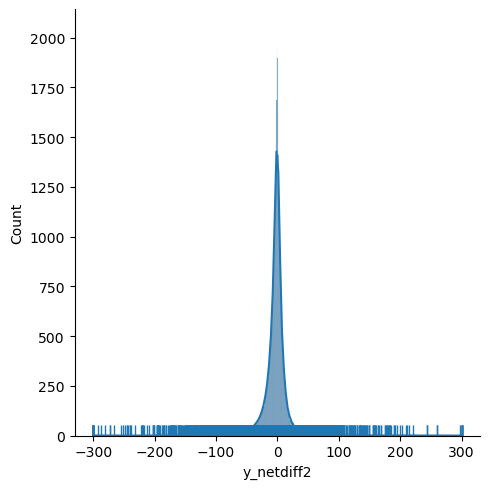

In [92]:
sns.displot(df["y_netdiff2"], kde = True, rug = True)

Shapiro-Wilk Test - Test Statistic: 0.6836906671524048, p-value: 0.0


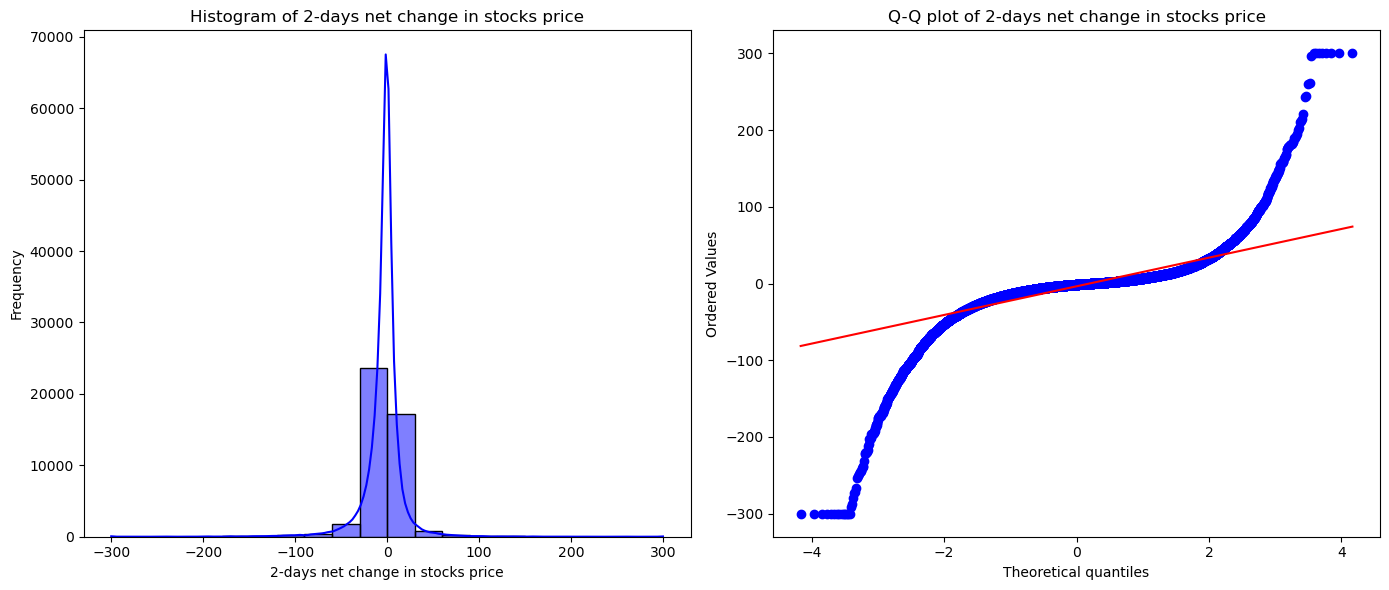

In [238]:
# TEST OF NORMALITY USING RESIDUALS
# The Shapiro-Wilk test assesses whether the distribution of the data differs from a normal distribution.

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Extract the y variable
y = df["y_netdiff2"]

# Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_p_value = stats.shapiro(y)
print(f'Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of y variable
sns.histplot(y, kde=True, color='blue', bins=20, ax=ax1)
ax1.set_title('Histogram of 2-days net change in stocks price')
ax1.set_xlabel('2-days net change in stocks price')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(y, dist="norm", plot=ax2)
ax2.set_title('Q-Q plot of 2-days net change in stocks price')
ax2.set_xlabel('Theoretical quantiles')
ax2.set_ylabel('Ordered Values')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


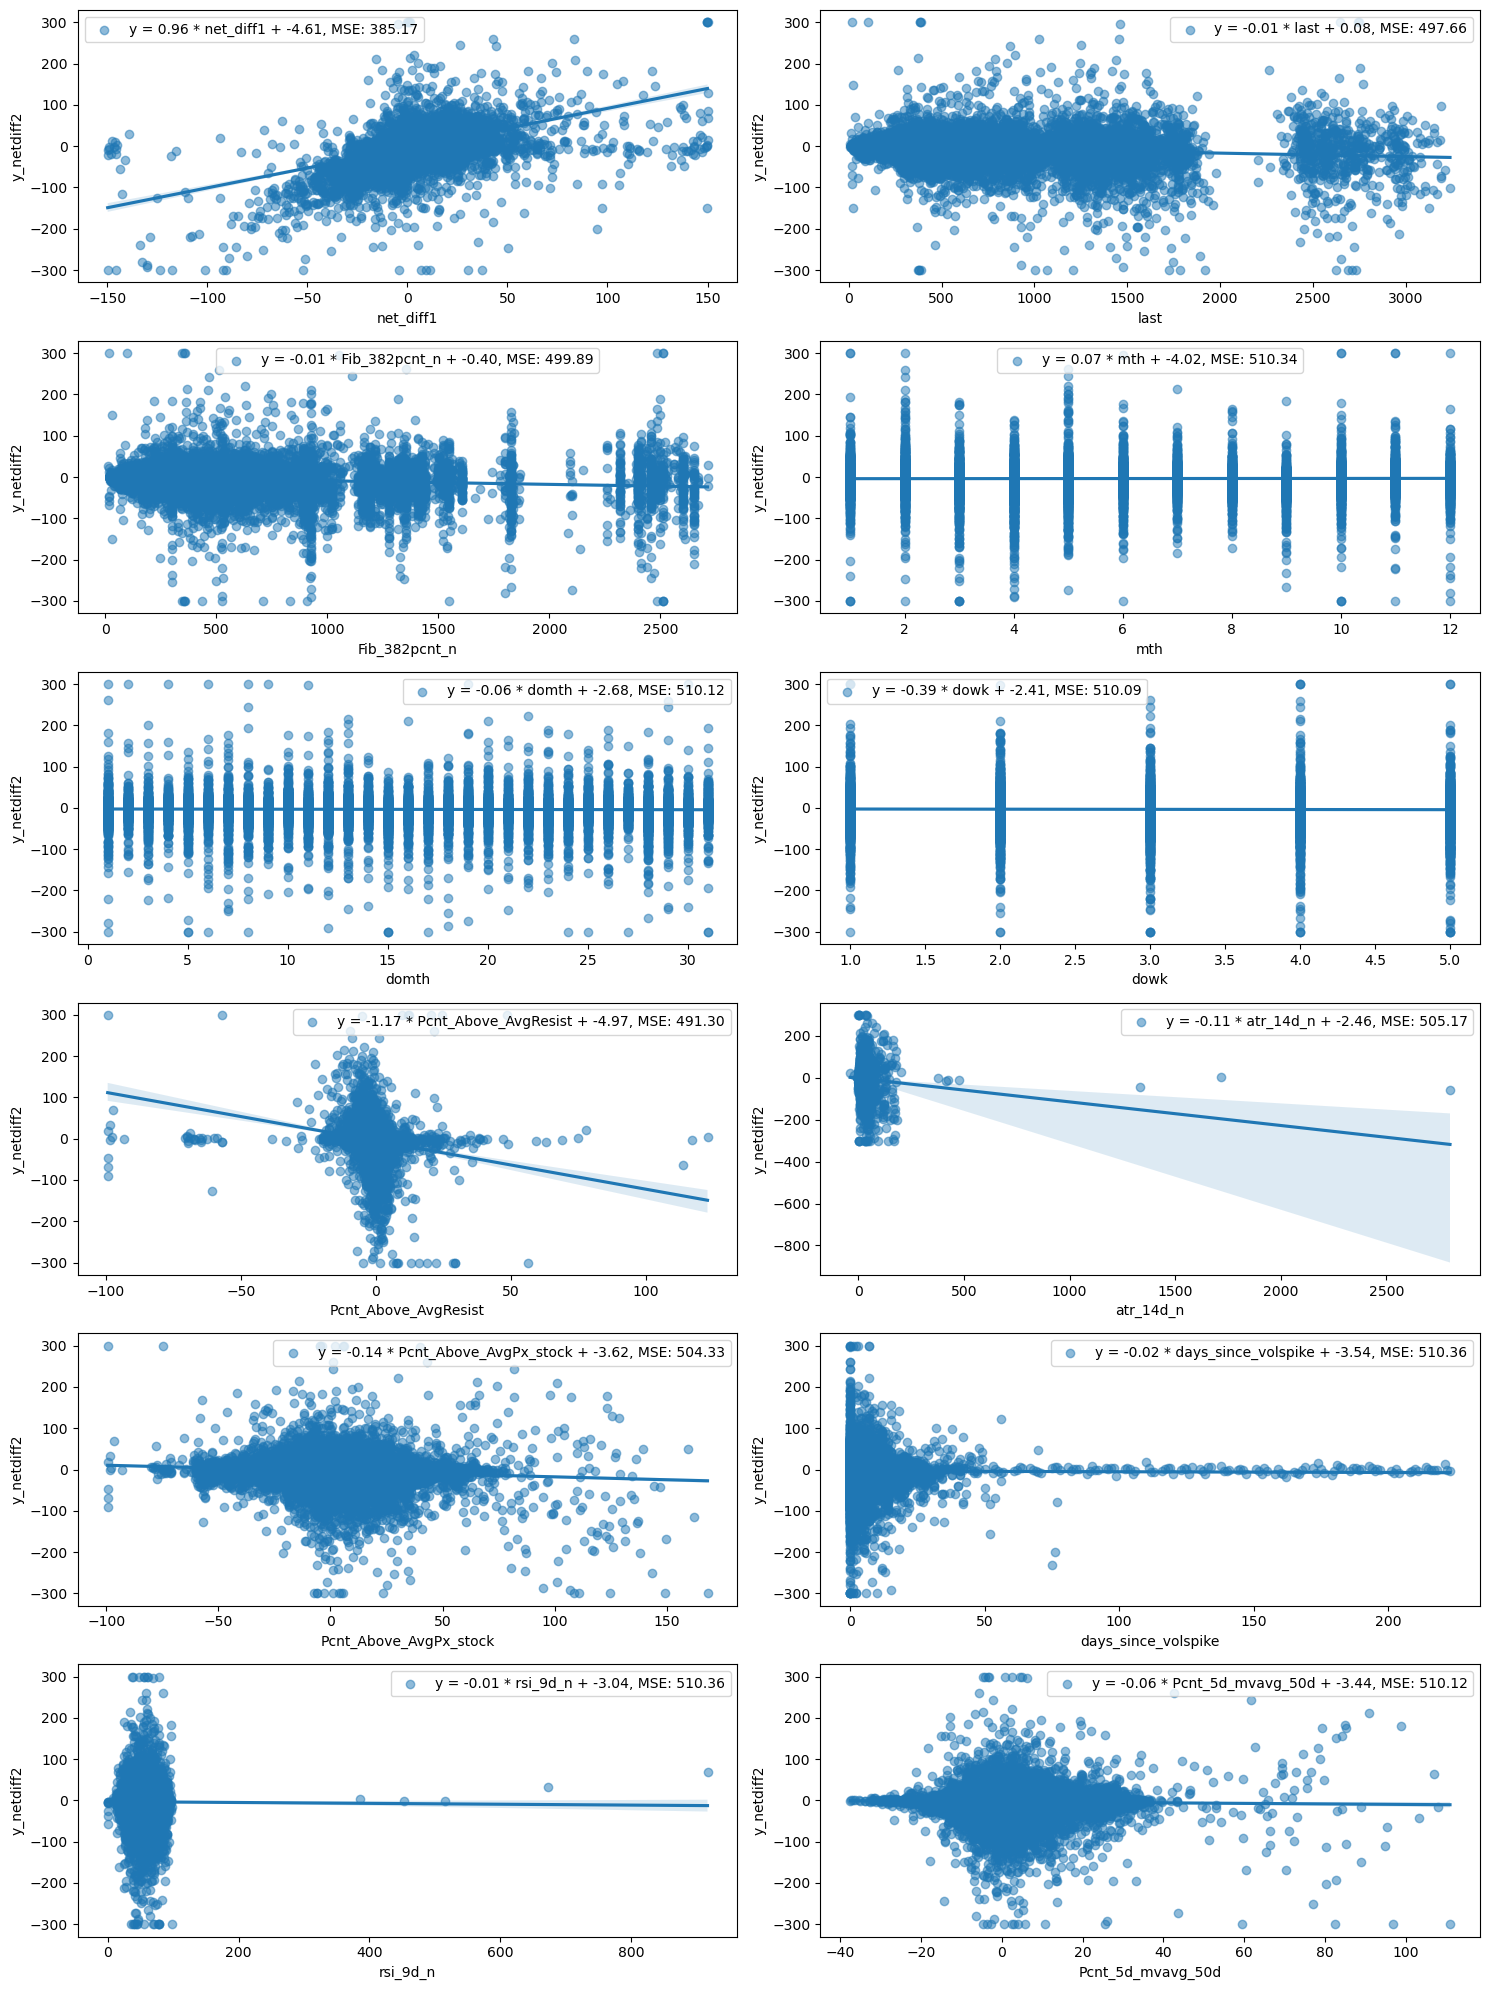

In [243]:
# Bivariate modeling & visualizations

# Define predictors (X) and target variable (y)
#X = df[['net_diff1','mth','wk','dowk','domth','last','key_chartp','rsi_3d_n','rsi_3d_pchg1','rsi_9d_n','rsi_9d_pchg1','rsi_9d_pchg2','rsi_9d_pchg5','rsi_20d_n','Pcnt_stoch3','Pcnt_k_stoch_d','Pcnt_di14d_up_above_dn','Pcnt_5d_mvavg_50d','Pcnt_Above_mvavg_5d','Pcnt_Above_mvavg_50d','Pcnt_Above_mvavg_20d', 'Pcnt_Above_mvavg_200d', 'Pcnt_Above_bb20dl','Pcnt_Above_AvgResist', 'Pcnt_Above_AvgPx_stock', 'crit9_52wk_ratio','pt_below_52wk_high', 'pt_above_floor', 'pt_below_ceil','pchg_floor_min1', 'pchg_floor_min0', 'pchg_ceil_max0', 'macd_9d_n','macd_14d_pchg2','macd_14d_n','Fib_382pcnt_n','dcr','days_since_volspike', 'days_since_target_raised','days_since_highprob_bull', 'days_since_drop_8','days_since_bull_window', 'days_since_bull_strength','days_since_bull_stoch', 'days_since_bull_rev','days_since_bull_hammer', 'days_since_bbl', 'bband_width', 'atr_3d_n','atr_9d_n', 'atr_14d_n']]

X = df[['net_diff1', 'last', 'Fib_382pcnt_n', 'mth', 'domth', 'dowk', 'Pcnt_Above_AvgResist',
        'atr_14d_n', 'Pcnt_Above_AvgPx_stock', 'days_since_volspike', 'rsi_9d_n',
        'Pcnt_5d_mvavg_50d']]
y = df['y_netdiff2']

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Create subplots for each predictor
fig, axes = plt.subplots(6, 2, figsize=(15, 20))
axes = axes.flatten()

# Plot each predictor against y with regression line
for i, predictor in enumerate(X.columns):
    sns.regplot(x=predictor, y=y, data=df, ax=axes[i], scatter_kws={'alpha':0.5})
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X_imputed[:, i].reshape(-1, 1), y)
    
    # Make predictions
    predictions = model.predict(X_imputed[:, i].reshape(-1, 1))
    
    # Calculate and display Mean Squared Error (MSE)
    mse = mean_squared_error(y, predictions)
    
    # Get slope (m) and intercept (b) of the regression line
    m = model.coef_[0]
    b = model.intercept_
    
    # Add equation to legend
    equation = f'y = {m:.2f} * {predictor} + {b:.2f}, MSE: {mse:.2f}'
    axes[i].legend([equation])

plt.tight_layout()
plt.show()


In [103]:
# Split data into training and testing sets

X = df.drop(columns=['y_netdiff2'])
y = df['y_netdiff2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(35688, 1377) (8922, 1377) (35688,) (8922,)


In [104]:
# Create a pipeline with scaling, feature selection (Lasso), and Lasso Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectFromModel(Lasso())),
    ('lasso', Lasso())
])

In [105]:
# Define Parameter Grid for GridSearchCV:
# Specify the grid of hyperparameters to search over using GridSearchCV. Here, you define the range of alpha values for Lasso regularization.
param_grid = {
    'lasso__alpha': 10**np.linspace(-5, 4, 100) 
}

# Perform GridSearch with K-fold Cross-Validation:
# Set up K-fold cross-validation within GridSearchCV to find the best hyperparameters (specifically the best alpha for Lasso Regression).

# Initialize KFold with number of folds
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV with the pipeline and parameter grid
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error', verbose=1)


In [106]:
# Fit GridSearchCV to find the best model
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('feature_selection',
                                        SelectFromModel(estimator=Lasso())),
                                       ('lasso', Lasso())]),
             param_grid={'lasso__alpha': array([1.00000000e-05, 1.23284674e-05, 1.51991108e-05, 1.87381742e-05,
       2.31012970e-05, 2.84803587e-05, 3.51119173e-05, 4.32876128e-05,
       5....
       8.11130831e+01, 1.00000000e+02, 1.23284674e+02, 1.51991108e+02,
       1.87381742e+02, 2.31012970e+02, 2.84803587e+02, 3.51119173e+02,
       4.32876128e+02, 5.33669923e+02, 6.57933225e+02, 8.11130831e+02,
       1.00000000e+03, 1.23284674e+03, 1.51991108e+03, 1.87381742e+03,
       2.31012970e+03, 2.84803587e+03, 3.51119173e+03, 4.32876128e+03,
       5.33669923e+03, 6.57933225e+03, 8.11130831e+03, 1.00000000e+04])},
             scoring='neg_mean_squared_error', verbose=1)

In [244]:
#  best alpha selected
best_alpha = grid_search.best_params_['lasso__alpha']
print(f"Best alpha selected: {best_alpha}")

Best alpha selected: 1.873817422860383


In [ ]:
# Evaluate Model Performance:
# After fitting the GridSearchCV, evaluate the performance of the best model on both training and testing data using Mean Squared Error (MSE) and R-squared.

In [107]:
# Predictions on training set
train_preds = grid_search.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)

# Predictions on test set
test_preds = grid_search.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

print(f'Training MSE: {train_mse:.4f}, R-squared: {train_r2:.4f}')
print(f'Testing MSE: {test_mse:.4f}, R-squared: {test_r2:.4f}')

# Obtain Significant Features and Model Equation:
# Retrieve significant features selected by Lasso Regression and obtain model parameters.

best_model = grid_search.best_estimator_
feature_names = X.columns[best_model.named_steps['feature_selection'].get_support()]
lasso_coefs = best_model.named_steps['lasso'].coef_

# Print significant features and their coefficients
for feature, coef in zip(feature_names, lasso_coefs):
    print(f'{feature}: {coef:.4f}')
    
# Compute F-test Statistics:
# Compute F-test statistics to test the overall significance of the model.

# Compute residuals
residuals = y_test - test_preds

# Compute degrees of freedom
dof_model = X_test.shape[1]  # Number of features
dof_residuals = X_test.shape[0] - dof_model - 1  # Total sample size - number of parameters - 1

# Compute F-statistic and p-value
f_statistic = (test_r2 / dof_model) / ((1 - test_r2) / dof_residuals)
p_value = f.cdf(f_statistic, dof_model, dof_residuals)

print(f'F-statistic: {f_statistic:.4f}, p-value: {p_value:.4f}')


Training MSE: 349.2381, R-squared: 0.3222
Testing MSE: 361.7354, R-squared: 0.2629
net_diff1: 3.5386
last: -0.9558
net_diff1^2: -1.2477
net_diff1 mth: 1.4307
net_diff1 wk: 0.0000
net_diff1 domth: 1.2673
net_diff1 last: 2.5713
net_diff1 key_chartp: 0.0000
net_diff1 rsi_9d_n: 1.7884
net_diff1 Pcnt_Above_AvgPx_stock: 0.3145
mth Pcnt_Above_AvgResist: -0.7548
dowk last: -0.3205
dowk Pcnt_stoch3: 0.0000
domth last: -0.0000
last Pcnt_Above_AvgResist: -0.6779
last Pcnt_Above_AvgPx_stock: -0.2424
rsi_9d_pchg5 dcr: 0.0000
Pcnt_stoch3 pt_below_52wk_high: 0.0000
Pcnt_k_stoch_d pchg_floor_min0: 0.0000
Pcnt_Above_mvavg_5d pt_above_floor: 0.0000
Pcnt_Above_AvgResist days_since_volspike: -0.2094
Pcnt_Above_AvgPx_stock^2: -0.0000
pchg_floor_min1 days_since_bull_strength: 0.0000
pchg_floor_min0 days_since_bull_strength: 0.0000
Fib_382pcnt_n atr_14d_n: -0.7964
days_since_bull_window atr_9d_n: -0.0000
F-statistic: 1.9537, p-value: 1.0000


In [117]:
lasso_coefs

array([ 3.5386263 , -0.95580999, -1.24774662,  1.43068918,  0.        ,
        1.26726375,  2.5713056 ,  0.        ,  1.78841114,  0.31453572,
       -0.75479679, -0.32054523,  0.        , -0.        , -0.6778839 ,
       -0.24235483,  0.        ,  0.        ,  0.        ,  0.        ,
       -0.20942687, -0.        ,  0.        ,  0.        , -0.79644785,
       -0.        ])

In [118]:
lasso_coefs.shape

(26,)

In [134]:
import numpy as np

# Assuming 'best_model' is obtained from GridSearchCV or another method
lasso_coefs = best_model.named_steps['lasso'].coef_

# Count non-zero coefficients
non_zero_count = np.count_nonzero(lasso_coefs)

print(f'Number of non-zero coefficients: {non_zero_count}')

Number of non-zero coefficients: 14


In [159]:
#DERIVE NON-ZERO INTERACTIONS AND POLYNOMIALS
df['net_diff1_sq'] = df['net_diff1']**2
df['net_diff1_mth'] = df['net_diff1']*df['mth']
df['net_diff1_domth'] = df['net_diff1']*df['domth']
df['net_diff1_last'] = df['net_diff1']*df['last']
df['net_diff1_rsi'] = df['net_diff1']*df['rsi_9d_n']
df['net_diff1_avgpx'] = df['net_diff1']*df['Pcnt_Above_AvgPx_stock']
df['mth_avgresist'] = df['mth']*df['Pcnt_Above_AvgResist']
df['dowk_last'] = df['dowk']*df['last']
df['last_avgresist'] = df['last']*df['Pcnt_Above_AvgResist']
df['last_avgpx'] = df['last']*df['Pcnt_Above_AvgPx_stock']
df['avgresist_ds_volspike'] = df['Pcnt_Above_AvgResist']*df['days_since_volspike']
df['Fib_atr'] = df['Fib_382pcnt_n']*df['atr_14d_n']


In [162]:
df.columns

Index(['net_diff1', 'mth', 'wk', 'dowk', 'domth', 'last', 'key_chartp',
       'rsi_3d_n', 'rsi_3d_pchg1', 'rsi_9d_n',
       ...
       'net_diff1_domth', 'net_diff1_last', 'net_diff1_rsi', 'net_diff1_avgpx',
       'mth_avgresist', 'dowk_last', 'last_avgresist', 'last_avgpx',
       'avgresist_ds_volspike', 'Fib_atr'],
      dtype='object', length=1390)

In [161]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44610 entries, 0 to 44609
Columns: 1390 entries, net_diff1 to Fib_atr
dtypes: float64(1390)
memory usage: 473.1 MB


In [185]:
# Keep important variables only
# Lasso selected features (plus interactions): 'net_diff1','last','Fib_382pcnt_n','mth','domth','dowk','Pcnt_Above_AvgResist','atr_14d_n','Pcnt_Above_AvgPx_stock','days_since_volspike','rsi_9d_n'
# interactions: 'net_diff1_sq','net_diff1_mth','net_diff1_domth', 'net_diff1_last', 'net_diff1_rsi', 'net_diff1_avgpx','mth_avgresist', 'dowk_last', 'last_avgresist', 'last_avgpx', 'avgresist_ds_volspike', 'Fib_atr'
# Other important predictors to re-test: Pcnt_5d_mvavg_50d
df_updated = df

selected_variables = ['net_diff1','last','Fib_382pcnt_n','mth','domth','dowk','Pcnt_Above_AvgResist','atr_14d_n','Pcnt_Above_AvgPx_stock','days_since_volspike','rsi_9d_n','net_diff1_sq','net_diff1_mth','net_diff1_domth', 'net_diff1_last', 'net_diff1_rsi', 'net_diff1_avgpx','mth_avgresist', 'dowk_last', 'last_avgresist', 'last_avgpx', 'avgresist_ds_volspike', 'Fib_atr','Pcnt_5d_mvavg_50d','y_netdiff2']

# Create a new DataFrame with only the selected variables
df = df_updated.loc[:, selected_variables]


In [186]:
df.columns

Index(['net_diff1', 'last', 'Fib_382pcnt_n', 'mth', 'domth', 'dowk',
       'Pcnt_Above_AvgResist', 'atr_14d_n', 'Pcnt_Above_AvgPx_stock',
       'days_since_volspike', 'rsi_9d_n', 'net_diff1_sq', 'net_diff1_mth',
       'net_diff1_domth', 'net_diff1_last', 'net_diff1_rsi', 'net_diff1_avgpx',
       'mth_avgresist', 'dowk_last', 'last_avgresist', 'last_avgpx',
       'avgresist_ds_volspike', 'Fib_atr', 'Pcnt_5d_mvavg_50d', 'y_netdiff2'],
      dtype='object')

In [187]:
# Impute missing values for remaining variables with median

# Identify numeric columns (int64 and float64)
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Calculate medians for each numeric column
medians = df[numeric_cols].median()

# Impute NaN values with respective column medians
df[numeric_cols] = df[numeric_cols].fillna(medians)



# print("Original DataFrame:")
# print(data.head(5))

# print("\nDataFrame after imputation with medians:")
# print(df.head(5))

In [188]:
# Select non-zero LASSO selected features/ predictors and fit a linear regression model with them
# Lasso selected features (plus interactions): 'net_diff1','last','Fib_382pcnt_n','mth','domth','dowk','Pcnt_Above_AvgResist','atr_14d_n','Pcnt_Above_AvgPx_stock','days_since_volspike','rsi_9d_n'
# interactions: 'net_diff1_sq','net_diff1_mth','net_diff1_domth', 'net_diff1_last', 'net_diff1_rsi', 'net_diff1_avgpx','mth_avgresist', 'dowk_last', 'last_avgresist', 'last_avgpx', 'avgresist_ds_volspike', 'Fib_atr'
# Other important predictors to re-test: Pcnt_5d_mvavg_50d

X = df[['net_diff1','last','Fib_382pcnt_n','mth','domth','dowk','Pcnt_Above_AvgResist','atr_14d_n','Pcnt_Above_AvgPx_stock','days_since_volspike','rsi_9d_n','Pcnt_5d_mvavg_50d','net_diff1_sq','net_diff1_mth','net_diff1_domth', 'net_diff1_last', 'net_diff1_rsi', 'net_diff1_avgpx','mth_avgresist', 'dowk_last', 'last_avgresist', 'last_avgpx', 'avgresist_ds_volspike', 'Fib_atr']]
#X = df[['net_diff1','last','Fib_382pcnt_n','mth','domth','dowk','Pcnt_Above_AvgResist','atr_14d_n','Pcnt_Above_AvgPx_stock','days_since_volspike','rsi_9d_n']]
y = df['y_netdiff2']


In [198]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import f, t
import numpy as np

# Define your features (X) and target (y)
X = df[['net_diff1', 'last', 'Fib_382pcnt_n', 'mth', 'domth', 'dowk', 'Pcnt_Above_AvgResist',
        'atr_14d_n', 'Pcnt_Above_AvgPx_stock', 'days_since_volspike', 'rsi_9d_n',
        'Pcnt_5d_mvavg_50d', 'net_diff1_sq', 'net_diff1_mth', 'net_diff1_domth',
        'net_diff1_last', 'net_diff1_rsi', 'net_diff1_avgpx', 'mth_avgresist',
        'dowk_last', 'last_avgresist', 'last_avgpx', 'avgresist_ds_volspike', 'Fib_atr']]
y = df['y_netdiff2']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit the linear regression model
linreg = LinearRegression()
linreg.fit(X_train, y_train)

# Predictions on training set
train_preds = linreg.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds)
train_r2 = r2_score(y_train, train_preds)

# Predictions on test set
test_preds = linreg.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds)
test_r2 = r2_score(y_test, test_preds)

# Compute degrees of freedom
dof_model = X_test.shape[1]  # Number of features
dof_residuals = X_test.shape[0] - dof_model - 1  # Total sample size - number of parameters - 1

# Compute F-statistic and p-value
f_statistic = (test_r2 / dof_model) / ((1 - test_r2) / dof_residuals)
p_value = f.cdf(f_statistic, dof_model, dof_residuals)

# Compute standard errors of coefficients
XtX_inv = np.linalg.inv(np.dot(X_train.T, X_train))
mse_residuals = np.sum((y_test - test_preds)**2) / (X_test.shape[0] - X_test.shape[1] - 1)
se_coef = np.sqrt(np.diagonal(mse_residuals * XtX_inv))

# Compute t-statistics and p-values for each coefficient
t_statistics = linreg.coef_ / se_coef
p_values = (1 - t.cdf(np.abs(t_statistics), dof_residuals)) * 2

# Print results
print(f'Training MSE: {train_mse:.4f}, R-squared: {train_r2:.4f}')
print(f'Testing MSE: {test_mse:.4f}, R-squared: {test_r2:.4f}')
print(f'F-statistic: {f_statistic:.4f}, p-value: {p_value:.4f}')

# Print coefficients, standard errors, t-statistics, and p-values
print("\nParameter Estimates, t-tests, and p-values:")
for i, (feature, coef) in enumerate(zip(X.columns, linreg.coef_)):
    print(f'{feature}:')
    print(f'  Coefficient Estimate: {coef:.4f}')
    print(f'  Standard Error: {se_coef[i]:.4f}')
    print(f'  t-statistic: {t_statistics[i]:.4f}')
    print(f'  p-value: {p_values[i]:.4f}')

# Model Equation
print("\nModel Equation:")
equation = "y = "
for i, (feature, coef) in enumerate(zip(X.columns, linreg.coef_)):
    if i == 0:
        equation += f'({coef:.4f} * {feature})'
    else:
        equation += f' + ({coef:.4f} * {feature})'
print(equation)



Training MSE: 323.9493, R-squared: 0.3609
Testing MSE: 364.1330, R-squared: 0.2977
F-statistic: 235.9304, p-value: 1.0000

Parameter Estimates, t-tests, and p-values:
net_diff1:
  Coefficient Estimate: 0.2880
  Standard Error: 0.0402
  t-statistic: 7.1660
  p-value: 0.0000
last:
  Coefficient Estimate: -0.0064
  Standard Error: 0.0012
  t-statistic: -5.3202
  p-value: 0.0000
Fib_382pcnt_n:
  Coefficient Estimate: 0.0047
  Standard Error: 0.0014
  t-statistic: 3.4447
  p-value: 0.0006
mth:
  Coefficient Estimate: -0.1780
  Standard Error: 0.0342
  t-statistic: -5.2055
  p-value: 0.0000
domth:
  Coefficient Estimate: -0.0248
  Standard Error: 0.0118
  t-statistic: -2.0980
  p-value: 0.0359
dowk:
  Coefficient Estimate: -0.0022
  Standard Error: 0.0941
  t-statistic: -0.0236
  p-value: 0.9811
Pcnt_Above_AvgResist:
  Coefficient Estimate: 0.2499
  Standard Error: 0.0633
  t-statistic: 3.9468
  p-value: 0.0001
atr_14d_n:
  Coefficient Estimate: -0.0012
  Standard Error: 0.0057
  t-statistic

In [189]:
lr = LinearRegression()
lr_model = lr.fit(X_train, y_train)

# cross validation
y_pred = lr_model.predict(X_test)

In [190]:
# measure of collinearity using VIF
def vif(exogs, df):
    vif_dict = {}

    for exog in exogs:
        not_exog = [i for i in exogs if i != exog]
        X, y = df[not_exog], df[exog]

        r_squared = LinearRegression().fit(X,y).score(X,y)

        # calculate VIF
        vif = 1/(1-r_squared)
        vif_dict[exog] = vif

    return pd.DataFrame({"VIF": vif_dict})

In [191]:
vif(X.columns, X).sort_values(by = 'VIF', ascending = False)

,VIF
last,22.207586
Fib_382pcnt_n,21.461232
net_diff1,19.320295
net_diff1_rsi,11.851309
dowk_last,6.930685
Fib_atr,6.575222
Pcnt_Above_AvgResist,4.515513
net_diff1_mth,3.770413
net_diff1_domth,3.735184
net_diff1_last,3.420056


In [192]:
# Compute residuals
residuals = y_test - y_pred
residuals.shape

(8922,)

In [193]:
residuals_df = pd.DataFrame(residuals, columns=["y_netdiff2"])
residuals_df.rename(columns={'y_netdiff2': 'Residuals'}, inplace=True)

Shapiro-Wilk Test - Test Statistic: 0.6524072289466858, p-value: 0.0


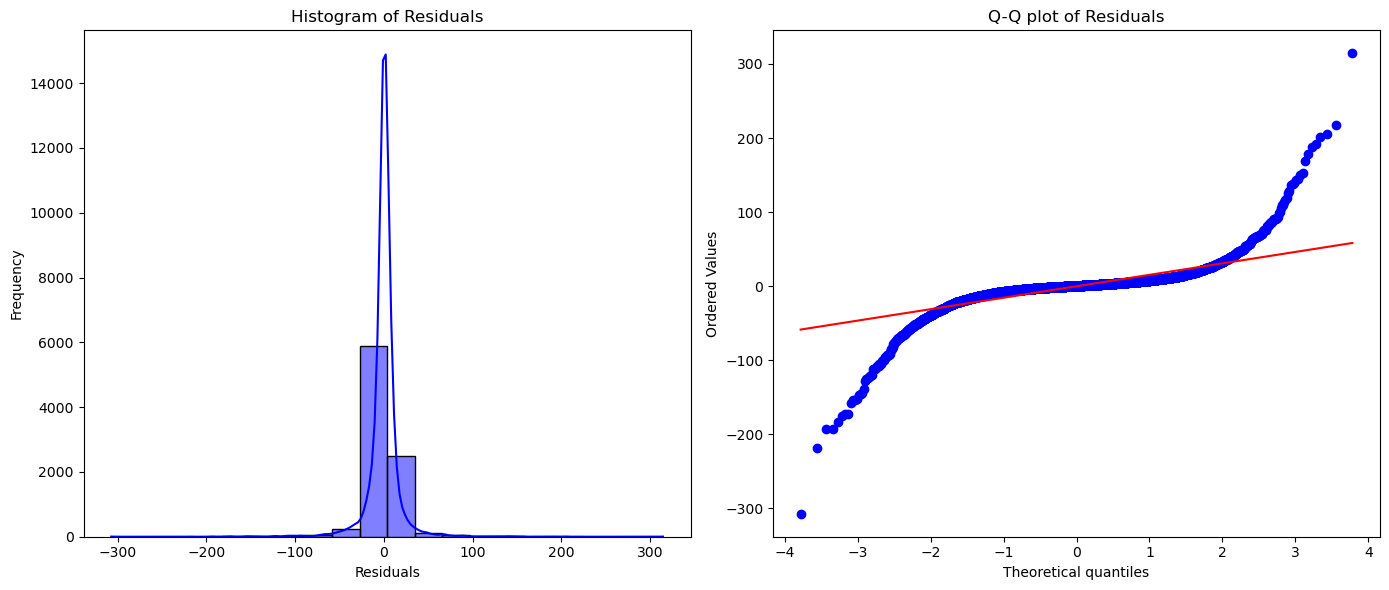

In [211]:
# TEST OF NORMALITY USING RESIDUALS
# The Shapiro-Wilk test assesses whether the distribution of the data differs from a normal distribution.

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


# Extract the y variable
y = residuals_df['Residuals']

# Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_p_value = stats.shapiro(y)
print(f'Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}')

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot histogram of y variable
sns.histplot(y, kde=True, color='blue', bins=20, ax=ax1)
ax1.set_title('Histogram of Residuals')
ax1.set_xlabel('Residuals')
ax1.set_ylabel('Frequency')

# Q-Q plot
stats.probplot(y, dist="norm", plot=ax2)
ax2.set_title('Q-Q plot of Residuals')
ax2.set_xlabel('Theoretical quantiles')
ax2.set_ylabel('Ordered Values')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


In [204]:
# BEST MODEL SELECTION by backward elimination
import statsmodels.api as sm

# Droping: 'net_diff1_sq', 'last_avgresist'

X = df[['net_diff1', 'last', 'Fib_382pcnt_n', 'mth', 'domth', 'dowk', 'Pcnt_Above_AvgResist',
        'atr_14d_n', 'Pcnt_Above_AvgPx_stock', 'days_since_volspike', 'rsi_9d_n',
        'Pcnt_5d_mvavg_50d', 'net_diff1_mth', 'net_diff1_domth',
        'net_diff1_last', 'net_diff1_rsi', 'net_diff1_avgpx', 'mth_avgresist',
        'dowk_last', 'last_avgpx', 'avgresist_ds_volspike', 'Fib_atr']]
y = df['y_netdiff2']

# Step 1: Split the dataset into training, validation, and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Step 2: Perform backward elimination on the training set
def backward_elimination(X, y, significance_level=0.05):
    model = LinearRegression()
    num_features = X.shape[1]
    for i in range(num_features):
        model.fit(X, y)
        p_values = sm.OLS(y, X).fit().pvalues[1:]  # Exclude the intercept
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            max_p_value_idx = p_values.idxmax()
            X = X.drop(max_p_value_idx, axis=1)
        else:
            break
    return model, X

# Fit the initial model and perform backward elimination
model, X_train_final = backward_elimination(X_train, y_train)

#print(X_train_final)


# Find the missing/dropped columns during backward elimination process
missing_cols = set(X_train.columns) - set(X_val.columns)

# Drop the columns from the training set too
X_train_final = X_train.drop(columns=missing_cols)

# Fit the model using the modified training set
model.fit(X_train_final, y_train)

# Step 3: Validate the model on the validation set
# Predict on the validation set
y_val_pred = model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)

# Step 4: Evaluate the final model on the test set
# Predict on the test set
y_test_pred = model.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)

# Print validation and test MSE
print("Validation MSE:", val_mse)
print("Test MSE:", test_mse)
print(missing_cols)

Validation MSE: 359.40029007588413
Test MSE: 366.41695516400415
set()


In [205]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_val.shape, y_val.shape)

(26766, 22) (8922, 22) (26766,) (8922,) (8922, 22) (8922,)


In [202]:

# MODEL EQUATION and PARAMETER ESTIMATES

# Fit the model using the modified training set
model.fit(X_train_final, y_train)

# Get parameter estimates (coefficients) and p-values
coefficients = model.coef_
intercept = model.intercept_

# Perform OLS regression using statsmodels to get p-values
X_train_final_with_intercept = sm.add_constant(X_train_final)  # Add intercept term
model_sm = sm.OLS(y_train, X_train_final_with_intercept).fit()
p_values = model_sm.pvalues

f_value = model_sm.fvalue
f_pvalue = model_sm.f_pvalue  # F-test p-value

r_squared = model_sm.rsquared
adj_r_squared = model_sm.rsquared_adj


# Make predictions on the validation set
y_val_pred = model.predict(X_val)

# Calculate Mean Squared Error (MSE)
val_mse = mean_squared_error(y_val, y_val_pred)

# Output parameter estimates, p-values, equation, and MSE
print("Parameter Estimates:")
for feature, coef, p_value in zip(X_train_final.columns, coefficients, p_values):
    print(f"{feature}: Coef = {coef:.4f}, p-value = {p_value:.4f}")
print(f"Intercept: {intercept:.4f}")

# Construct the equation
equation = f"y = {intercept:.4f} + "
for feature, coef in zip(X_train_final.columns, coefficients):
    equation += f"({coef:.4f} * {feature}) + "
equation = equation[:-3]  # Remove the trailing '+'

print("\nR-squared:", r_squared)
print("Adjusted R-squared:", adj_r_squared)

print("F-value:", f_value)
print("F-test p-value:", f_pvalue)

print(f"\nEquation: {equation}")
print(f"Mean Squared Error (MSE) on Validation Set: {val_mse:.4f}")
print(f"Mean Squared Error (MSE) on Test Set: {test_mse:.4f}")


Parameter Estimates:
net_diff1: Coef = 0.3621, p-value = 0.0001
last: Coef = -0.0043, p-value = 0.0000
Fib_382pcnt_n: Coef = 0.0007, p-value = 0.0004
mth: Coef = -0.1542, p-value = 0.6234
domth: Coef = -0.0229, p-value = 0.0000
dowk: Coef = -0.1228, p-value = 0.0713
Pcnt_Above_AvgResist: Coef = 0.2640, p-value = 0.2745
atr_14d_n: Coef = -0.0075, p-value = 0.0000
Pcnt_Above_AvgPx_stock: Coef = 0.0108, p-value = 0.2083
days_since_volspike: Coef = -0.0393, p-value = 0.2916
rsi_9d_n: Coef = 0.0428, p-value = 0.0032
Pcnt_5d_mvavg_50d: Coef = 0.0098, p-value = 0.0000
net_diff1_sq: Coef = -0.0037, p-value = 0.5760
net_diff1_mth: Coef = 0.0149, p-value = 0.0000
net_diff1_domth: Coef = 0.0062, p-value = 0.0000
net_diff1_last: Coef = 0.0002, p-value = 0.0000
net_diff1_rsi: Coef = 0.0033, p-value = 0.0000
net_diff1_avgpx: Coef = 0.0042, p-value = 0.0000
mth_avgresist: Coef = -0.0875, p-value = 0.0000
dowk_last: Coef = -0.0003, p-value = 0.0000
last_avgresist: Coef = -0.0008, p-value = 0.1079
last

In [206]:
# Compute residuals
residuals = y_test - y_pred
residuals.shape

(8922,)

In [207]:
residuals_df = pd.DataFrame(residuals, columns=["y_netdiff2"])
residuals_df.rename(columns={'y_netdiff2': 'Residuals'}, inplace=True)

Shapiro-Wilk Test - Test Statistic: 0.6524072289466858, p-value: 0.0


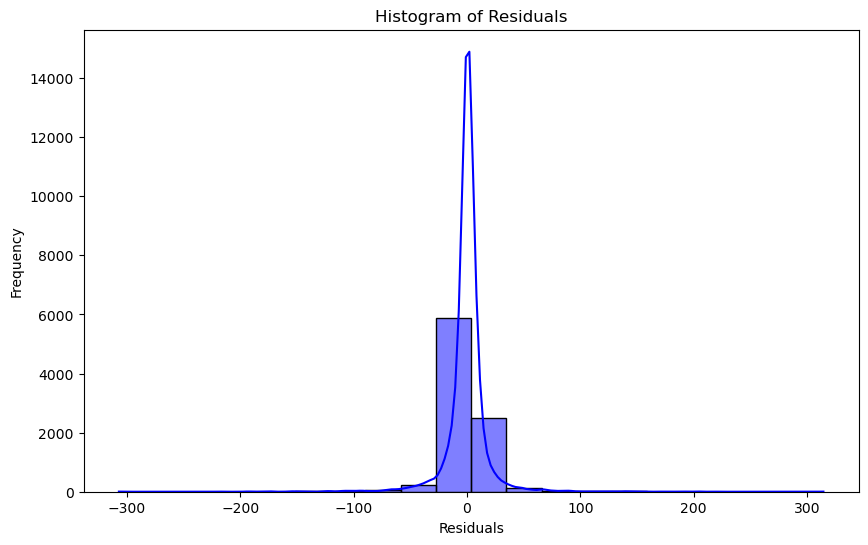

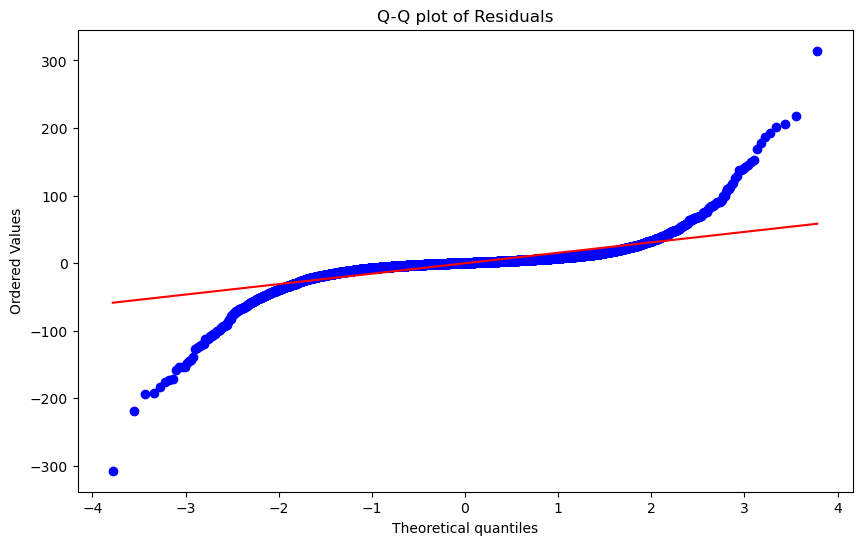

In [208]:
# TEST OF NORMALITY USING RESIDUALS
# The Shapiro-Wilk test assesses whether the distribution of the data differs from a normal distribution.

# Extract the y variable
y = residuals_df['Residuals']

# Shapiro-Wilk test for normality
shapiro_test_statistic, shapiro_p_value = stats.shapiro(y)
print(f'Shapiro-Wilk Test - Test Statistic: {shapiro_test_statistic}, p-value: {shapiro_p_value}')

# Plot histogram of y variable
plt.figure(figsize=(10, 6))
sns.histplot(y, kde=True, color='blue', bins=20)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(y, dist="norm", plot=plt)
plt.title('Q-Q plot of Residuals')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Ordered Values')
plt.show()